In [1]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy.stats
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
from nn_resampler import nn_resampler
from phase_est_smc import phase_est_smc

In [3]:
num_particles = 1000 # number of SMC particles (num of w points)
num_samples = 10000 # number of samples to draw from the particle distribution (to be binned)
num_bins = 100 # number of bins
n_iters = 1000 # number of different omega*
t0 = 0.1 # starting time
max_iters = 100 # maximum number of iterations before breaking
if_print = True

In [4]:
net = nn_resampler(100,100)
# net = net.to(device)
net.load_state_dict(torch.load("net_bn_aft_relu.model"))
net.eval()

nn_resampler(
  (enc1): Linear(in_features=100, out_features=75, bias=True)
  (enc2): Linear(in_features=75, out_features=50, bias=True)
  (enc3): Linear(in_features=50, out_features=25, bias=True)
  (enc4): Linear(in_features=25, out_features=10, bias=True)
  (dec1): Linear(in_features=10, out_features=25, bias=True)
  (dec2): Linear(in_features=25, out_features=50, bias=True)
  (dec3): Linear(in_features=50, out_features=75, bias=True)
  (dec4): Linear(in_features=75, out_features=100, bias=True)
  (bn_enc1): BatchNorm1d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_enc2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_enc3): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_enc4): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_dec1): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_dec2): BatchNorm1d(50, ep

## NN Resampler

In [5]:
omega_star_list = []
nn_pred_list = []
nn_data = []

for i in range(n_iters): 
    
    omega_star = np.random.uniform(low=-1, high =1) * np.pi
    
    omega_star_list.append(omega_star)
    smc = phase_est_smc(omega_star, t0, max_iters)
    smc.init_particles(num_particles)
    resample_counts = 0
#     running_est = []
    
    while True:
        
        particle_pos, particle_wgts = smc.particles(threshold=num_particles/5, num_measurements=1)
        bins, edges, mean, std = smc.get_bins(num_bins, num_samples)
        
        if smc.break_flag:
            break
            
        nn_pred = net(torch.tensor(bins).float().unsqueeze(0)) ## convert to float tensor, then make dim [1, num_bins]
        smc.nn_resample(nn_pred.detach().numpy(), edges, mean, std)
        
        resample_counts += 1

        
#         if len(running_est) > 5:
#             last_n = running_est[-5:]
#             # np.allclose(a,b) returns true if every element in a and b are equal to a tolerance
#             # np.full_like makes an array with shake of last_n with every element being last_n[0]
#             # if all elements of last_n are equal then they should all equal the first element
#             if np.allclose(last_n, np.full_like(last_n, last_n[0])):
#                 break
    if if_print:            
        print("True omega: {:f}, prediction by NN: {:f}, num of resample calls: {:d}".format(omega_star,
                                                                                             smc.curr_omega_est,
                                                                                             resample_counts))

    while len(smc.data) < max_iters:
        smc.data.append(smc.data[-1]) # append the last estimate
    
    if abs(smc.curr_omega_est - omega_star) > 1:
        print("Prediction: {:f}, actual value: {:f}. Threshold exceeded. Breaking out of loop for inspection.".
             format(smc.curr_omega_est, omega_star))
        break
                                                                                             
    nn_data.append(smc.data)
    nn_pred_list.append(smc.curr_omega_est)

True omega: 1.977882, prediction by NN: 2.298851, num of resample calls: 5
True omega: 0.269867, prediction by NN: 0.253910, num of resample calls: 9
True omega: -2.493839, prediction by NN: -2.397402, num of resample calls: 4
True omega: -1.359471, prediction by NN: -1.397971, num of resample calls: 6
True omega: 2.163065, prediction by NN: 2.723643, num of resample calls: 7
True omega: -2.316665, prediction by NN: -2.316643, num of resample calls: 7
True omega: 1.057890, prediction by NN: 1.065340, num of resample calls: 5
True omega: 0.157988, prediction by NN: 0.205534, num of resample calls: 8
True omega: 3.034558, prediction by NN: 2.534644, num of resample calls: 4
True omega: -0.429177, prediction by NN: -0.423049, num of resample calls: 5
True omega: 1.433043, prediction by NN: 1.764571, num of resample calls: 5
True omega: -2.184976, prediction by NN: -1.951715, num of resample calls: 3
True omega: 0.060074, prediction by NN: 0.153446, num of resample calls: 5
True omega: -0.

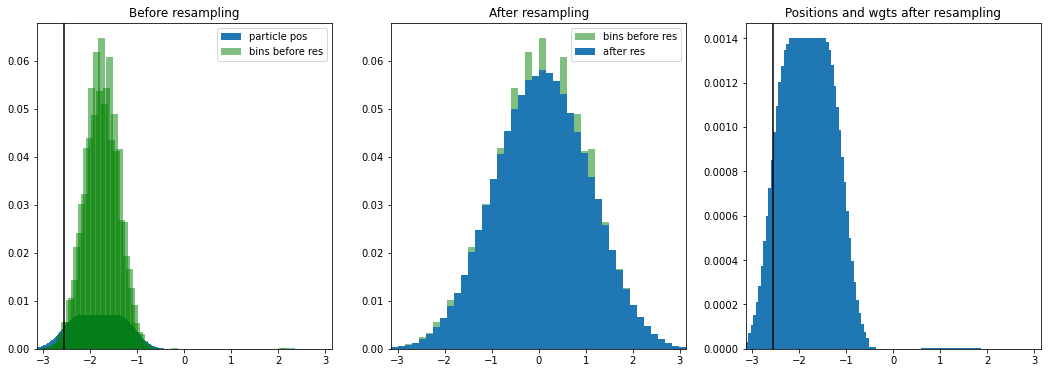

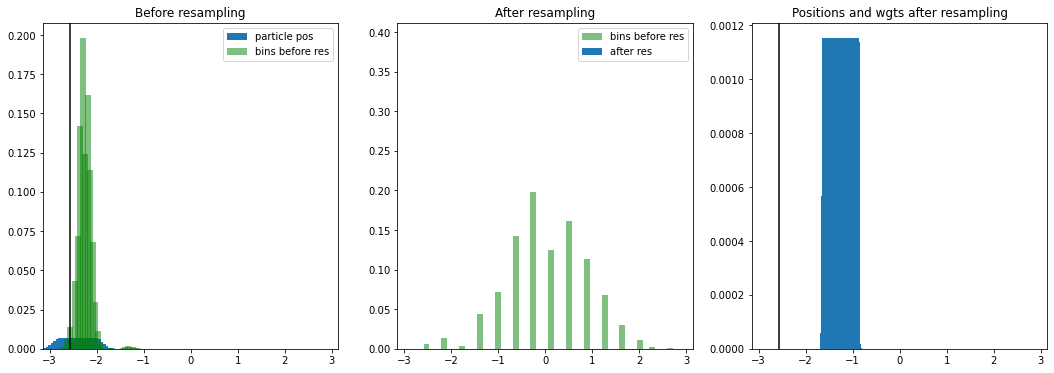

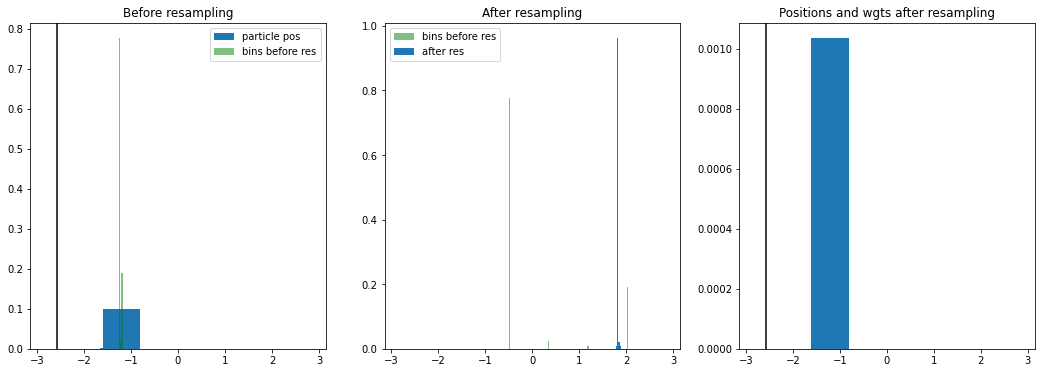

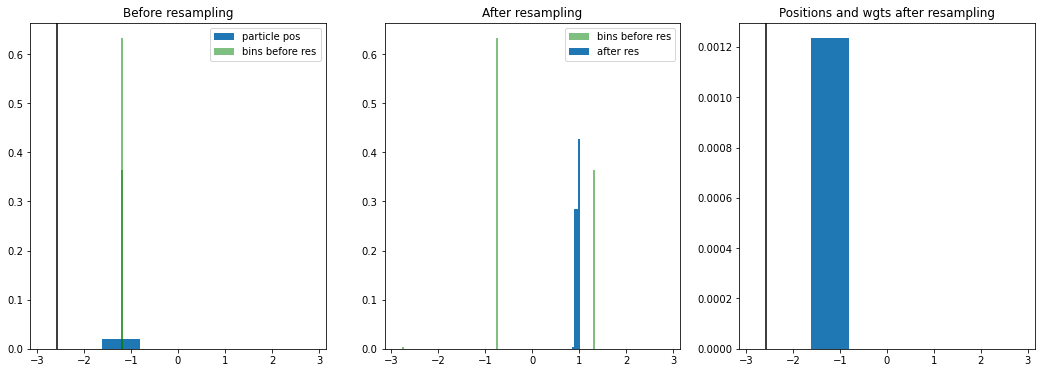

In [9]:
for i in range(len(smc.memory.pos_wgt_bef_res)-1):
    pos_bef_res = smc.memory.pos_wgt_bef_res[i][0]
    wgt_bef_res = smc.memory.pos_wgt_bef_res[i][1]
    bins_bef_res = smc.memory.bins_edges_bef_res[i][0]
    edges_bef_res = smc.memory.bins_edges_bef_res[i][1]
    mean = smc.memory.mean_std_bef_res[i][0]
    std = smc.memory.mean_std_bef_res[i][1]
    bins_aft_res = smc.memory.bins_edges_aft_res[i][0]
    edges_aft_res = edges_bef_res
    pos_aft_res = smc.memory.pos_wgt_aft_res[i][0]
    wgt_aft_res = smc.memory.pos_wgt_aft_res[i][1]
    edge_width = edges_bef_res[1] - edges_bef_res[0]
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,6))
    
    ax1.bar(pos_bef_res, wgt_bef_res, label='particle pos')
    ax1.bar(edges_bef_res*std + mean, bins_bef_res, align='edge', width = edge_width, alpha=0.5,color='green', label='bins before res')
    ax1.set_xlim([-np.pi, np.pi])
    ax1.axvline(omega_star,color='black')
    ax1.set_title("Before resampling")
    ax1.legend()
    
    ax2.bar(edges_bef_res, bins_bef_res, align='edge', width = edge_width, label='bins before res', color='green',alpha=0.5)
    ax2.bar(edges_aft_res, bins_aft_res, align='edge', width = edge_width, label='after res')
    ax2.set_xlim([-np.pi, np.pi])
    #ax2.axvline(omega_star, color='black')
    ax2.set_title("After resampling")
    ax2.legend()
    
    ax3.bar(pos_aft_res, wgt_aft_res)
    ax3.axvline(omega_star, color='black')
    ax3.set_xlim([-np.pi, np.pi])
    ax3.set_title("Positions and wgts after resampling")
    
    plt.show()
    
    

In [ ]:
nn_mse = np.mean( np.array(omega_star_list) - np.array(nn_pred_list) ) ** 2
print(nn_mse)

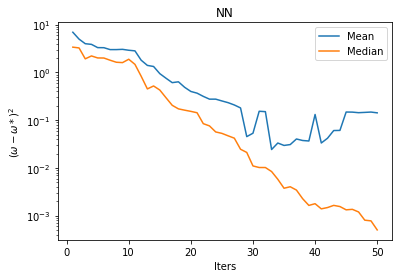

In [28]:
nn_data_squared = (np.array(nn_data) - np.array(omega_star_list).reshape(-1,1)) ** 2 
nn_data_mean = np.mean(nn_data_squared, axis=0)
nn_data_median = np.median(nn_data_squared, axis =0)

num_data_points = nn_data_squared.shape[1]

plt.plot(np.arange(1,num_data_points+1, dtype=int), nn_data_mean, label='Mean')
plt.plot(np.arange(1,num_data_points+1, dtype=int), nn_data_median, label='Median')
plt.legend()
plt.title("NN")
plt.yscale('log')
plt.xlabel("Iters")
plt.ylabel("$(\omega - \omega*)^2$")
plt.show()

## Liu-West resampler

In [28]:
omega_star_list = []
lw_pred_list = []
lw_data = []

for i in range(n_iters): 
    omega_star = np.random.uniform(low=-1, high=1) * np.pi
    
    omega_star_list.append(omega_star)
    smc = phase_est_smc(omega_star, t0, max_iters)
    smc.init_particles(num_particles)
#     running_est = []
    
    counts = 0
    
    while True:

        particle_pos, particle_wgts = smc.particles(threshold=num_particles/10, num_measurements=1)
        smc.liu_west_resample()
        
#         if counts == 0:
#             fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
#             ax1.bar(particle_pos, particle_wgts)
#             ax2.bar(smc.particle_pos, smc.particle_wgts)
#             plt.show()
        
        counts+= 1 
        
        curr_omega_est = smc.particle_pos[np.argmax(smc.particle_wgts)]
        if smc.break_flag == True:
            break
            
#         running_est.append(curr_omega_est)
        
#         if len(running_est) > 5:
#             last_5 = running_est[-5:]
#             # np.allclose(a,b) returns true if every element in a and b are equal to a tolerance
#             # np.full_like makes an array with shape of last_10 with every element being last_10[0]
#             # if all elements of last_10 are equal then they should all equal the first element
#             if np.allclose(last_5, np.full_like(last_5, last_5[0])):
#                 break
                
      
    print("True omega: {:f}, prediction by LW: {:f}, num of resample calls: {:d}".format(omega_star,curr_omega_est, counts))
    lw_pred_list.append(curr_omega_est)

    while len(smc.data) < max_iters:
        smc.data.append(smc.data[-1]) # append the last estimate 
    
    lw_data.append(smc.data)

True omega: 1.663447, prediction by LW: -0.889965, num of resample calls: 16
True omega: -3.073195, prediction by LW: -2.319638, num of resample calls: 16
True omega: 0.031518, prediction by LW: -0.908551, num of resample calls: 17
True omega: 0.848015, prediction by LW: -3.241614, num of resample calls: 16
True omega: -2.908357, prediction by LW: -6.894360, num of resample calls: 17
True omega: 1.646334, prediction by LW: -12.796095, num of resample calls: 17
True omega: -2.173925, prediction by LW: -0.034696, num of resample calls: 16
True omega: -0.409590, prediction by LW: 10.375502, num of resample calls: 17
True omega: -2.540218, prediction by LW: -0.454790, num of resample calls: 17
True omega: 0.770224, prediction by LW: 4.618110, num of resample calls: 17
True omega: 1.444547, prediction by LW: -4.024705, num of resample calls: 16
True omega: -0.242292, prediction by LW: 4.823263, num of resample calls: 16
True omega: 1.464682, prediction by LW: 3.813804, num of resample calls

In [29]:
lw_mse = np.mean( np.array(omega_star_list) - np.array(lw_pred_list)) ** 2
print(lw_mse)

0.004967827418478848


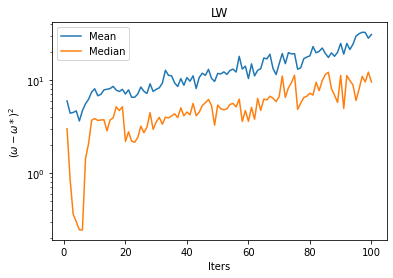

In [30]:
lw_data_squared = (np.array(lw_data) - np.array(omega_star_list).reshape(-1,1)) ** 2 
lw_data_mean = np.mean(lw_data_squared, axis=0)
lw_data_median = np.median(lw_data_squared, axis =0)

num_data_points = lw_data_squared.shape[1]

plt.plot(np.arange(1,num_data_points+1, dtype=int), lw_data_mean, label='Mean')
plt.plot(np.arange(1,num_data_points+1, dtype=int), lw_data_median, label='Median')
plt.legend()
plt.title("LW")
plt.xlabel("Iters")
plt.ylabel("$(\omega - \omega*)^2$")
plt.yscale('log')
plt.show()